<a href="https://colab.research.google.com/github/Saoban123/Hamoye-Projects/blob/main/Hamoye_kaggle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import gc


In [2]:
train_df = pd.read_csv('/content/train_classes.csv')
train_df

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road
...,...,...
40474,train_40474,clear primary
40475,train_40475,cloudy
40476,train_40476,agriculture clear primary
40477,train_40477,agriculture clear primary road


In [3]:
train_df['tags'].value_counts()

clear primary                                               13636
partly_cloudy primary                                        3630
cloudy                                                       2089
clear primary water                                          1850
agriculture clear primary road                               1680
                                                            ...  
agriculture clear cultivation cultivation road                  1
artisinal_mine bare_ground partly_cloudy primary road           1
agriculture clear conventional_mine primary road                1
clear conventional_mine habitation road                         1
agriculture partly_cloudy primary road conventional_mine        1
Name: tags, Length: 449, dtype: int64

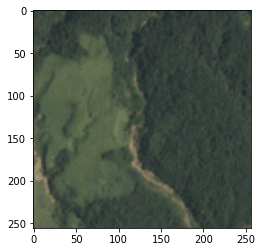

In [4]:
train_img = mpimg.imread('/content/train_1.jpg')
plt.imshow(train_img)

In [5]:
train_img.shape

(256, 256, 4)

In [6]:
en = LabelEncoder()
label_maps = pd.DataFrame(['agriculture', 'artisinal_mine', 'bare_ground',\
                      'blooming','blow_down','clear','cloudy',\
                      'conventional_mine','cultivation','habitation','haze', \
                      'partly_cloudy','primary','road','selective_logging',\
                      'slash_burn','water'], columns = ['tags'])
label_maps['map'] = en.fit_transform(label_maps)
label_maps.set_index('tags',inplace = True)
label_maps = label_maps.to_dict()
label_maps

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


{'map': {'agriculture': 0,
  'artisinal_mine': 1,
  'bare_ground': 2,
  'blooming': 3,
  'blow_down': 4,
  'clear': 5,
  'cloudy': 6,
  'conventional_mine': 7,
  'cultivation': 8,
  'habitation': 9,
  'haze': 10,
  'partly_cloudy': 11,
  'primary': 12,
  'road': 13,
  'selective_logging': 14,
  'slash_burn': 15,
  'water': 16}}

In [7]:
#defining a dict of encoded labels
label_map = {'agriculture': 0,
 'artisinal_mine': 1,
 'bare_ground': 2,
 'blooming': 3,
 'blow_down': 4,
 'clear': 5,
 'cloudy': 6,
 'conventional_mine': 7,
 'cultivation': 8,
 'habitation': 9,
 'haze': 10,
 'partly_cloudy': 11,
 'primary': 12,
 'road': 13,
 'selective_logging': 14,
 'slash_burn': 15,
 'water': 16}

In [8]:
#loading training images
from tqdm import tqdm 
import cv2
import numpy as np
from sklearn.utils import shuffle

X = []
Y = []
train_df = shuffle(train_df,random_state=0)
for image_name, tags in tqdm(train_df.values, miniters=400):
    arr = cv2.imread('/content/{}.jpg'.\
                     format(image_name), cv2.IMREAD_UNCHANGED)
    targets = np.zeros(17)
    for t in tags.split(' '):
      try:
        targets[label_map[t]] = 1
        arr = cv2.resize(arr, (64, 64))
        X.append(arr)
        Y.append(targets)   
      except:
        break
X = np.array(X, np.float16)/255.0

100%|██████████| 40479/40479 [00:04<00:00, 8639.39it/s]


In [9]:
#splitting into training and validation sets

from sklearn.model_selection import train_test_split
import numpy as np

X = np.array(X)
Y = np.array(Y)
x_train, x_val, y_train, y_val = train_test_split(X, Y, test_size = 0.2, shuffle = True, random_state = 1)

print(x_train.shape, y_train.shape, x_val.shape, y_val.shape)

(4, 64, 64, 3) (4, 17) (2, 64, 64, 3) (2, 17)


In [10]:
gc.collect()

87

In [11]:
import numpy as np
from keras import backend as K
from sklearn.metrics import fbeta_score

def fbeta(y_true, y_pred, threshold_shift=0):
    beta = 2

    # just in case of hipster activation at the final layer
    y_pred = K.clip(y_pred, 0, 1)

    # shifting the prediction threshold from .5 if needed
    y_pred_bin = K.round(y_pred + threshold_shift)

    tp = K.sum(K.round(y_true * y_pred_bin)) + K.epsilon()
    fp = K.sum(K.round(K.clip(y_pred_bin - y_true, 0, 1)))
    fn = K.sum(K.round(K.clip(y_true - y_pred, 0, 1)))
    
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)

    beta_squared = beta ** 2
    return (beta_squared + 1) * (precision * recall) / (beta_squared * precision + recall + K.epsilon())

In [12]:
from keras.layers import Conv2D, Dense, LSTM, Flatten, MaxPooling2D, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow import keras

#with tpu_strategy.scope():
model = keras.Sequential()
model.add(Conv2D(64, 5, 2, activation = "relu", input_shape = (64, 64, 3)))
model.add(MaxPooling2D())
model.add(Conv2D(128, 5, 2, activation = "relu"))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(512, activation = "relu"))
model.add(Dense(17, activation = "sigmoid"))
model.compile(loss = "binary_crossentropy", optimizer = Adam(), metrics = [fbeta])
model.fit(x_train, y_train, validation_data = (x_val, y_val), epochs = 45, batch_size = 64)

Epoch 1/45
1/1 [==============================] - 1s 1s/step - loss: 0.6862 - fbeta: 0.4545 - val_loss: 0.6118 - val_fbeta: 0.6667
Epoch 2/45
1/1 [==============================] - 0s 52ms/step - loss: 0.6104 - fbeta: 0.7353 - val_loss: 0.4914 - val_fbeta: 0.7812
Epoch 3/45
1/1 [==============================] - 0s 49ms/step - loss: 0.4837 - fbeta: 0.9028 - val_loss: 0.3533 - val_fbeta: 0.7812
Epoch 4/45
1/1 [==============================] - 0s 49ms/step - loss: 0.3240 - fbeta: 0.9028 - val_loss: 0.2855 - val_fbeta: 0.7812
Epoch 5/45
1/1 [==============================] - 0s 53ms/step - loss: 0.2064 - fbeta: 0.9028 - val_loss: 0.3063 - val_fbeta: 0.7812
Epoch 6/45
1/1 [==============================] - 0s 51ms/step - loss: 0.1773 - fbeta: 0.9028 - val_loss: 0.2979 - val_fbeta: 0.7812
Epoch 7/45
1/1 [==============================] - 0s 53ms/step - loss: 0.1677 - fbeta: 0.9028 - val_loss: 0.2194 - val_fbeta: 0.7812
Epoch 8/45
1/1 [==============================] - 0s 47ms/step - loss: 

In [13]:
 y_train_pred = np.round(model.predict(x_train))
 y_val_pred = np.round(model.predict(x_val))

In [14]:
model.evaluate(x_val, y_val)

print("train fscore: ", fbeta_score(y_train, y_train_pred,beta = 2.0, average = 'weighted'))
print("val fscore: ", fbeta_score(y_val, y_val_pred, beta = 2.0, average = 'weighted'))



1/1 [==============================] - 0s 21ms/step - loss: 0.0026 - fbeta: 1.0000
train fscore:  1.0
val fscore:  1.0


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


In [15]:
submission_csv = pd.read_csv('/content/sample_submission.csv')
submission_csv

,image_name,tags
0,test_0,primary clear agriculture road water
1,test_1,primary clear agriculture road water
2,test_2,primary clear agriculture road water
3,test_3,primary clear agriculture road water
4,test_4,primary clear agriculture road water
...,...,...
61186,file_9995,primary clear agriculture road water
61187,file_9996,primary clear agriculture road water
61188,file_9997,primary clear agriculture road water
61189,file_9998,primary clear agriculture road water


In [16]:
test = submission_csv[0 : 40669]
files = submission_csv[40669 : ]

In [17]:
gc.collect()

3015

In [19]:
test_img = []

for image_name, tags in tqdm(test.values, miniters=1000):
  try:
    arr = cv2.imread('/content/{}.jpg'.format(image_name))
    test_img.append(cv2.resize(arr, (64, 64)))
  except:
    pass


for image_name, tags in tqdm(files.values, miniters=1000):
  try:
    arr = cv2.imread('/content/{}.jpg'.format(image_name))
    test_img.append(cv2.resize(arr, (64, 64)))
  except:
    pass
  

test_img = np.array(test_img, np.float16)/255.0




100%|██████████| 20522/20522 [00:02<00:00, 9135.27it/s]


In [20]:
yres = []
predictions = model.predict(test_img, batch_size = 64, verbose = 2)
yres.append(predictions)

1/1 - 0s - 17ms/epoch - 17ms/step


In [21]:
sub = np.array(yres[0])
for i in range (1, len(yres)):
    sub += np.array(yres[i])
sub = pd.DataFrame(sub, columns = label_map)


In [24]:
#saving my final result into a csv file
preds = []
for i in tqdm(range(sub.shape[0]), miniters=1000):
    a = sub.loc[[i]]
    a = a.apply(lambda x: x > 0.2, axis=1)
    a = a.transpose()
    a= a.loc[a[i] == True]
    ' '.join(list(a.index))
    preds.append(' '.join(list(a.index)))
  
#len(preds)

new_submission = submission_csv
#new_submission['tags'] = preds
new_submission.to_csv('submission.csv', index=False)

100%|██████████| 2/2 [00:00<00:00, 201.22it/s]


In [25]:
p = pd.read_csv('/content/submission.csv')
p

,image_name,tags
0,test_0,primary clear agriculture road water
1,test_1,primary clear agriculture road water
2,test_2,primary clear agriculture road water
3,test_3,primary clear agriculture road water
4,test_4,primary clear agriculture road water
...,...,...
61186,file_9995,primary clear agriculture road water
61187,file_9996,primary clear agriculture road water
61188,file_9997,primary clear agriculture road water
61189,file_9998,primary clear agriculture road water
